In [ ]:
import csv
import random
import math

class PointGeneration:
  '''
  Class for random generation of points using uniform random distribution
  and storing the points as required in an array or a csv file.
  '''

  def __init__(self):
    self.array=[]

  def dist(self, i, tup2): # dist between ith point and tup2
    return math.sqrt((self.array[i][0] - tup2[0])**2 + (self.array[i][1] - tup2[1])**2)

  def eligibility(self, tup):
    for i in range(len(self.array)):
      if(self.dist(i, tup) < 400 or self.array[i] == tup):
        return False
    return True
  
  def csv_file(self):
    with open('coords.csv', 'w', newline = '') as file:
      fieldnames = ['x', 'y']
      writer = csv.DictWriter(file, fieldnames = fieldnames)
      writer.writeheader()
      for i in range(len(self.array)):
        writer.writerow({'x':self.array[i][0], 'y':self.array[i][1]})

  def pointsGeneration(self): # generates random points and adds them to self.array
    turbines = 0
    while(turbines < 50):
      points = (random.uniform(50, 3950), random.uniform(50, 3950)) 
      if(self.eligibility(points)):
        self.array.append(points)
        turbines+=1
    return self.array
  

  def __str__(self):
    return str(self.array)
  


In [ ]:
from Farm_Evaluator_Vec import getTurbLoc, loadPowerCurve, binWindResourceData, getAEP, preProcessing
import numpy as np

class IndividualGeneration:
  """ 
    1. Set turbine radius to 50
    2. Use getTurbLoc to load the turbine locations
    3. Load powercurve using loadPowerCurve function
    4. Load windinstanceprobabilities using binWindResourceData
    5. Perform preprocessing
    6. Call getAEP
  """
  def __init__(self, pop_size, file_name):
    '''
    INPUTS: 
    pop_size - Number of wind farms taken into consideration for one generation
    '''
    self.file_name=file_name
    self.pop_size=pop_size
    self.turb_rad = 50
    self.power_curve = loadPowerCurve("power_curve.csv")
    self.wind_inst_freq = binWindResourceData(file_name+".csv")
    self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t = preProcessing(self.power_curve)

  def individual(self):
    '''
    Calculates output for a randomly generated farm with AEP for a paricular year.
    '''
    p=PointGeneration()
    ind = p.pointsGeneration() # array of random turb coords
    p.csv_file() # loads turb coords to "coords.csv"
    turb_coords = getTurbLoc("coords.csv")
    result = getAEP(self.turb_rad, turb_coords, self.power_curve, self.wind_inst_freq, self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t)
    return ind, result
  
  def create_csv_file(self, year , POP_index):
    '''
    Function used for creating the csv file for the best AEP output
    of the year 20'i'
    '''
    filename = "best_"+str(year)+".csv"
    with open(filename, 'w', newline = '') as file:
      fieldnames = ['x', 'y']
      writer = csv.DictWriter(file, fieldnames = fieldnames)
      writer.writeheader()
      for i in range(len(POP_index)):
        writer.writerow({'x':POP_index[i][0], 'y':POP_index[i][1]})
  
  def individual_later(self, P):
    '''
    Calculates output for a given farm for a particular year
    '''
    with open('coords.csv', 'w', newline = '') as file:
      fieldnames = ['x', 'y']
      writer = csv.DictWriter(file, fieldnames = fieldnames)
      writer.writeheader()
      for i in range(len(P)):
        writer.writerow({'x':P[i][0], 'y':P[i][1]})
    turb_coords = getTurbLoc("coords.csv")
    result = getAEP(self.turb_rad, turb_coords, self.power_curve, self.wind_inst_freq, self.n_wind_instances, self.cos_dir, self.sin_dir, self.wind_sped_stacked, self.C_t)
    return result

  def searchSorted(self, sample_array):
    """
    Returns lookup indices for closest values w.r.t sample_array elements
    
    :called_from
        turbine_power
    
    :param
        sample_array - Array, whose elements need to be matched
                       against lookup elements. 
        
    :return
        lookup indices for closest values w.r.t sample_array elements 
    """
    lookup = self.power_curve[:,0]
    lookup_middles = lookup[1:] - np.diff(lookup.astype('f'))/2
    idx1 = np.searchsorted(lookup_middles, sample_array)
    indices = np.arange(lookup.shape[0])[idx1]
    return indices
  
  def turbine_power(self, turb_coords):
    '''
    Calculates power output delivered by each turbine of an individual
    '''
    n_turbs        =   turb_coords.shape[0]
    assert n_turbs ==  50, "Error! Number of turbines is not 50."

    rotate_coords   =  np.zeros((self.n_wind_instances, n_turbs, 2), dtype=np.float32)
    rotate_coords[:,:,0] =  np.matmul(self.cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(self.sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    rotate_coords[:,:,1] =  np.matmul(self.sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(self.cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    
    x_dist = np.zeros((self.n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(self.n_wind_instances):
        tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
        x_dist[i] = tmp - tmp.transpose()

    y_dist = np.zeros((self.n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(self.n_wind_instances):
        tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
        y_dist[i] = tmp - tmp.transpose()
    y_dist = np.abs(y_dist) 

    sped_deficit = (1-np.sqrt(1-self.C_t))*((self.turb_rad/(self.turb_rad + 0.05*x_dist))**2) 
    sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (self.turb_rad + 0.05*x_dist))))] = 0.0
    sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))
    wind_sped_eff     = self.wind_sped_stacked*(1.0-sped_deficit_eff)

    indices = self.searchSorted(wind_sped_eff.ravel())
    power   = self.power_curve[indices,2]
    power   = power.reshape(self.n_wind_instances, n_turbs)
    wind_prob = np.column_stack([self.wind_inst_freq]*50)
    power = power*wind_prob
    power = np.sum(power, axis=0)
    power = power*8.76

    return power

  def generate(self):
    '''
    RETURN VALUES: 
    POP - Coordinates of turbines for entire population
    IND_OUTPUT - Individual output of each turbine for the entire population
    AEP - Total AEP of each wind farm for entire population
    '''
    POP=[]
    IND_OUTPUT=[]
    AEP=[]
    for i in range(self.pop_size):
      ind,result = self.individual()
      POP.append(ind)
      AEP.append(result)
      power = self.turbine_power(np.array(ind))
      IND_OUTPUT.append(power)
    return POP, AEP, IND_OUTPUT

  def generate_later(self, POP):
    '''
    This function is for generating the AEP and IND_OUTPUT values
    for an already generated population
    '''
    IND_OUTPUT=[]
    AEP=[]
    for i in range(self.pop_size):
      result = self.individual_later(POP[i])
      AEP.append(result)
      power = self.turbine_power(np.array(POP[i]))
      IND_OUTPUT.append(power)
    return AEP, IND_OUTPUT




In [ ]:
import statistics


class GA:
  '''
  All the implementations are done for one generation
  Defines required parameters and has functions for the implementing
  Monte Carlo Cross Elitist Genetic Algorithm
  Have done both Explorative and Exploitive analysis using Ud treshold
  Parameters:            A[Population, Sp1, Sp2, GG, pb, PM1, PM2, DM]
  Values for Explorative: [330, Sp1, Sp2, 0.9, 0.90, 0.99, 0.8, 70]
  Values for Exploitive:  [330, Sp1, Sp2, 0.9, 0.95, 0.99, 0.1,70]
  '''
  
  def __init__(self, Sp1, Sp2, pb, PM2, POP, AEP, IND_OUTPUT):
    self.Sp1 = Sp1
    self.Sp2 = Sp2
    self.pb = pb
    self.PM2 = PM2
    self.population = 350
    self.GG =0.9
    self.PM1 =0.99
    self.DM =85
    self.POP=POP
    self.AEP=AEP
    self.IND_OUTPUT=IND_OUTPUT
  
  def Distance(self, index, nm):
    for j in range(50):
      if index!=j:
        if np.linalg.norm(np.array(nm[index])-np.array(nm[j]))<400:
          nm[index]=(random.uniform(50, 3950), random.uniform(50, 3050))
          self.Distance(index, nm)
    return nm

  def selection_crossover(self):
    '''
    This method creates POP_SEL which contains the selcted population and AEP_SEL,
    containing the corresponding AEPs
    Since it pops the values from the original list, the remaining list contains the
    values which were not selected
    POP contains coordinates of 330 individuals
    AEP contains their respective AEP for the given year
    IND_OUTPUT contains individual outputs of each of the turbines in a particular individual
    '''

    population_selected=int(max(self.population*(1-self.GG),1))
    POP_SEL=[]
    AEP_SEL=[]
    IND_OUTPUT_SEL=[]

    median_AEP = statistics.median(self.AEP)
    noise_AEP = median_AEP*(self.Sp1 + self.Sp2*(random.uniform(0,1)-random.uniform(0,1)))
    score=[0]*self.population
    for i in range(self.population):
      score[i]= AEP[i]-noise_AEP
    
    res=dict(zip(range(self.population), score))
    dict1 = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
    sort_aep = list(dict1)

    for i in range(population_selected):
      a=sort_aep[self.population-1-i]
      POP_SEL.append(POP[a])
      #AEP_SEL.append(AEP[a])
      IND_OUTPUT_SEL.append(IND_OUTPUT[a])
      del dict1[a]

    for key in dict1:
      a = POP[key]
      a1 = random.choice(POP_SEL)
      a1_index=POP_SEL.index(a1)
      a1_indi=IND_OUTPUT_SEL[a1_index]
      a2 = random.choice(POP_SEL)
      while(a2 != a1):
        a2 = random.choice(POP_SEL)
      a2_index=POP_SEL.index(a2)

      max_a1=max(IND_OUTPUT_SEL[a1_index])
      nm=[]
      nm1=[]
      for i in range(50):
        if a1_indi[i]>self.pb * max_a1:
          nm.append(a1[i])
        else:
          nm1.append(a1[i])
      
      for i in range(len(nm1)):
        Min_Dist=40000
        max_out=0
        coord=(0,0)
        turb_coord_a=a[i]
        for j in a2:
          Dist= np.linalg.norm(np.array(turb_coord_a)-np.array(j))
          if Min_Dist>Dist:
            Min_Dist=Dist
            quo=IND_OUTPUT_SEL[a2_index].index(j)
            if max_out<quo:
              max_out=quo
              coord=j
            else:
              coord=turb_coord_a
        nm.append(coord)


      #Mutation
      for i in range(len(nm)):
        r1=random.uniform(0,1)
        r2=random.uniform(0,1)
        r3=random.uniform(0,1)
        r4=random.uniform(0,1)
        x_new = nm[i][0]
        y_new = nm[i][1]
        if self.PM1 > r1 :
          if self.PM2 > r2 :
            x_new = x_new+(self.DM)*(r3-r4)
            y_new = y_new+(self.DM)*(r3-r4)
        
        #Constraint conditions
        if x_new<50 or x_new>3950:
            x_new = x_new+(self.DM)*(r4-r3)
        if y_new<50 or y_new>3950:
            y_new = y_new+(self.DM)*(r4-r3)
        
        nm[i]=(x_new, y_new)

        nm = self.Distance(i, nm)
      
      POP[key]=nm
    return POP


In [ ]:
#Explorative

IG=IndividualGeneration(350, "wind_data_2007")
POP, AEP, IND_OUTPUT = IG.generate()
print("07")
print(max(AEP))
MAX_AEP=max(AEP)

for j in range(50):
  for i in ["08","09","13","14","15","17","07"]:
    POP=GA(1.002,0.02,0.8,0.9,POP, AEP, IND_OUTPUT).selection_crossover()
    file_name="wind_data_20"+str(i)
    IG=IndividualGeneration(350,file_name)
    AEP, IND_OUTPUT = IG.generate_later(POP)
    current_AEP = max(AEP)
    print(i)
    print(current_AEP)
    index=AEP.index(current_AEP)
    if current_AEP>MAX_AEP:
      with open('best.csv', 'w', newline = '') as file:
        fieldnames = ['x', 'y']
        writer = csv.DictWriter(file, fieldnames = fieldnames)
        writer.writeheader()
        for k in range(len(POP[index])):
          writer.writerow({'x':POP[index][k][0], 'y':POP[index][k][1]})
    
    IG.create_csv_file(i, POP[index])
    MAX_AEP=current_AEP



07
516.8816372680664
08
511.67009490966797
09
468.1998179626465
13
484.1955130004883
14
459.2719990539551
15
573.1386657714844
17
558.2439523315429
07
518.5861587524414
08
513.8590255737305
09
469.97795654296874
13
485.4696936035156
14
460.6016514587402
15
574.0089715576172
17
559.0941078186036
07
519.5053866577149
08
513.8590255737305
09
469.97795654296874
13
486.37231338500976
14
461.0305554199219
15
574.3921948242188
17
559.5488095092774
07
520.048074645996
08
514.8921377563477
09
471.0008432006836
13
486.9352185058594
14
461.6174871826172
15
575.3006625366211
17
560.4029415893555
07
520.8134852600098
08
515.3310333251953
09
471.3772494506836
13
487.21986236572263
14
461.9170349121094
15
575.3006625366211
17
560.535238494873
07
520.8134852600098
08
515.3310333251953
09
471.3772494506836
13
487.2551838684082
14
461.9170349121094
15
575.5847048950195
17
561.208218383789
07
521.2515454101563
08
515.4999215698242
09
471.92498336791994
13
487.4642056274414
14
462.2565490722656
15
576.142

In [ ]:
#Exploitive 
for j in range(20):
  for i in ["08","09","13","14","15","17","07"]:
    POP=GA(1.002,0.02,0.95,0.1,POP, AEP, IND_OUTPUT).selection_crossover()
    file_name="wind_data_20"+str(i)
    IG=IndividualGeneration(350,file_name)
    AEP, IND_OUTPUT = IG.generate_later(POP)
    current_AEP = max(AEP)
    print(i)
    print(current_AEP)
    index=AEP.index(current_AEP)
    if current_AEP>MAX_AEP:
      with open('best.csv', 'w', newline = '') as file:
        fieldnames = ['x', 'y']
        writer = csv.DictWriter(file, fieldnames = fieldnames)
        writer.writeheader()
        for k in range(len(POP[index])):
          writer.writerow({'x':POP[index][k][0], 'y':POP[index][k][1]})
    
    IG.create_csv_file(i, POP[index])
    MAX_AEP=current_AEP

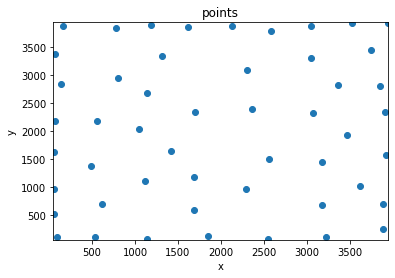

In [ ]:
'''
For visualization purposes 
'''
import matplotlib.pyplot as plt
import csv
import numpy as np

x = []
y = []

with open('best_15.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        x.append(row[0])
        y.append(row[1])
      
X=np.float32(x[1:])
Y=np.float32(y[1:])
fig = plt.figure()
ax = plt.axes()
ax.scatter(X,Y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('points')
plt.xlim(50,3950)
plt.ylim(50,3950)
plt.show()